In [1]:
# -- LOG -- #
import logging as log
log.basicConfig(filename='./Logs/classic.log',
                filemode='w',
                format='[%(asctime)s]:[%(name)s]:(%(levelname)s): %(message)s',
                level=log.INFO)

In [2]:
# -- IMPORTS -- #
try:
    from keras.applications.vgg16 import VGG16
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.preprocessing import image as kerasImage
    from PIL import Image as pilImage
    from scipy.ndimage.filters import gaussian_filter, median_filter
    %matplotlib inline
    import matplotlib.pyplot as plt
    import keras.backend as K
    import imageio
    import subprocess
    import numpy as np
    import os
except Exception as e:
    log.error('Failed -- IMPORT:\n',exc_info=True)
    raise SystemExit(0)

Using TensorFlow backend.


In [3]:
# -- DEFINE MODEL -- #
model = VGG16(weights='imagenet',include_top=True)
weights = model.layers[-1].get_weights()
vgg16Model = Sequential()
for layer in model.layers[:-1]:
    layer.trainable = False
    vgg16Model.add(layer)
vgg16Model.add(Dense(1000,activation='linear'))
vgg16Model.layers[-1].set_weights(weights)
vgg16Model.layers[-1].trainable = False
imgInput = vgg16Model.inputs[0]
prediction = vgg16Model.outputs[0]
vgg16Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [4]:
# -- DEFINE FUNCTIONS -- #
def deprocess_image(x):    
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.25
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
# -- ACTIVATION MAXIMIZATION FOR ONE FILTER OF A SPECIFIC LAYER -- #
if not os.path.isdir('./Results/Classic'):
    os.mkdir('./Results/Classic')
    log.info('Directory created.')
    
# -- DEFINE HYPERPARAMETERS -- #
size = vgg16Model.input_shape[1:][0]
learningRate = 12000
l2Decay = 0.0
medianFilterSize = 5
medianFilterEvery = 4
earlyStop = 0
blurStd = 0.12
blurEvery = 20

# -- NESTEROV HYPERPARAMETERS -- #
momentum = 0.9
velocity = np.zeros(vgg16Model.input_shape[1:])

# -- SELECT CLASS TO MAXIMIZE -- #
epochs = int(input('Select the number of iterations:'))
selClass = int(input('Select the class you want to maximize (0-{0})'.format(prediction.get_shape()[1]-1)))
option = int(input('Select the Method of gradient: Classic(0), Nesterov(1)'))
gifImg = []

# -- DEFINE LOSS & GRADIENT -- #
loss = prediction[0,selClass]
grads = K.gradients(loss,imgInput)[0]
iterate = K.function([imgInput],[loss,grads])

Select the number of iterations: 800
Select the class you want to maximize (0-999) 4
Select the Method of gradient: Classic(0), Nesterov(1) 1


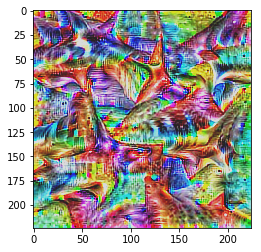

In [6]:
# -- START ITERATION -- #
imgInputData = np.random.normal(0,10,(1,size,size,3))
log.info('Starting Iterations')
gifImg.append(imgInputData[0].copy())
for k in range(epochs):
    if option == 0:
        lossVal,gradVal = iterate([imgInputData])
        imgInputData += gradVal*learningRate
    elif option == 1:
        lossVal,gradVal = iterate([imgInputData+momentum*velocity])
        velocity = momentum*velocity+learningRate*gradVal
        imgInputData += velocity
    else:
        log.error('Option introduced not supported.')
        break
    # -- EARLY STOPPING -- #
    log.info('Current loss value:'+str(lossVal))
    if earlyStop is not 0 and lossVal >= earlyStop:
        log.info('Early Stopping achieved on epoch: '+str(k))
        break
    # -- CLIPPING -- #
    imgInputData = np.clip(imgInputData,0,255).astype('float32')
    # -- REGULARIZATION -- #
    if k != epochs-1:
        if l2Decay > 0:
            imgInputData *= (1-l2Decay)
        if blurStd is not 0 and k % blurEvery == 0:
            imgInputData = gaussian_filter(imgInputData, sigma=[0, blurStd, blurStd, 0])
        if medianFilterSize is not 0 and k % medianFilterEvery == 0 :
            imgInputData = median_filter(imgInputData, size=(1, medianFilterSize, medianFilterSize, 1))
    gifImg.append(imgInputData[0].copy())
    
# -- SAVE RESULTS -- #
img = deprocess_image(imgInputData[0])
log.info('Saving Final Image. Size:'+str(img.shape))
plt.imshow(img)
plt.show()
img = kerasImage.array_to_img(img,scale=False)
img.save('./Results/Classic/Class_'+str(selClass)+'.png')

In [12]:
# -- CREATE GIF -- #
log.info('Creating GIF of '+str(len(gifImg[0::20]))+' Images.')
with imageio.get_writer('./Results/Classic/'+str(selClass)+'.gif', mode='I') as writer:
    for im in gifImg:
        image = deprocess_image(im.copy())
        writer.append_data(image)
log.info('DONE')

In [13]:
# -- DRAW MOSAIC OF PROGRESS -- #
margin = 5
stop = False
mosaic = []
for im in gifImg[0::50]:
    mosaic.append(deprocess_image(im.copy()))
n = int(np.round(np.sqrt(len(mosaic))))
cols = size*n+(n-1)*margin
rows = size*n+(n-1)*margin
draw = np.zeros((cols,rows,3),dtype='uint8')
log.info('The dimensions of the Mosaic are: '+str(draw.shape))
im = 0
for c in range(n):
    if not stop:
        for r in range(n):
            wM = (size+margin)*c
            hM = (size+margin)*r
            draw[wM:wM+size,hM:hM+size,:] = mosaic[im]
            im += 1
            if(im >= len(mosaic)):
                stop = True
                break
    else:
        break
kerasImage.save_img('./Results/Classic/Mosaic_'+str(selClass)+'.png',draw)
log.info('DONE')